## Introduction to SNT Programming

This notebook provides a basic example of accessing the [SNT API](https://morphonets.github.io/SNT/). Before starting, we need to make [SNT](https://imagej.net/SNT) accessible from this notebook through [pyimagej](https://pypi.org/project/pyimagej/). To install it (if you haven't done so):

In [5]:
#!conda install --yes --prefix {sys.prefix} -c conda-forge pyimagej openjdk=8

Once installed, `imagej` is imported as any other module:

In [3]:
import os
import sys
import imagej

Next, we must initialize ImageJ within the notebook environment. Initialization can be done with GUI support or in headless mode. There are two ways to accomplish this:
1. Specifying a remote path for Fiji. This allows, e.g., for the direct execution on [Binder](https://mybinder.org/v2/gh/morphonets/SNT/master?filepath=%2Fnotebooks%2Fbasic_example.ipynb) (no local files are required) but the installation times are prohibitively long.
2. Specifying a local Fiji installation (subscribed to the NeuroAnatomy update site). This is significantly faster, and  the preferred way. [ijfinder.py](ijfinder.py) can be used to streamline this task. Simply [insert](ijfinder.py) the absolute path to your 'Fiji.app' directory under `local_fiji_dir`, and its location will be shared across all of SNT notebooks in this collection. If the directory is not found, the script will prompt you for an alternative:


In [4]:
import ijfinder
fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

Now that Fiji is initialized we can import ```jnius```. Note this must be done AFTER ImageJ (Fiji) is initialized.

In [5]:
from jnius import autoclass, cast

As would be done in a Jython script using Fiji's Script Editor, we need to import the SNT classes we want to use.
The ```jnius.autoclass()``` function allows us to do exactly that, simply pass the full classpath as an argument to the function.

The most up-to-date API is found at https://morphonets.github.io/SNT/

For example, to download a neuron reconstruction from the MouseLight database and calculate summary statistics on it, you would import the [MouseLightLoader](https://morphonets.github.io/SNT/sc/fiji/snt/io/MouseLightLoader.html) and [TreeStatistics](https://morphonets.github.io/SNT/sc/fiji/snt/analysis/TreeStatistics.html) classes, as shown in the following cell.

In [6]:
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
TreeStatistics = autoclass('sc.fiji.snt.analysis.TreeStatistics')

Now you can access all the attributes and methods these classes offer. 

Let's get a summary of the inter-node distances for a specific mouse cortical motor neuron (ID = "AA0100" in the [MouseLight database](http://ml-neuronbrowser.janelia.org/)).

First, we initialize ```MouseLightLoader``` with the ID String of the desired reconstruction. The loader object has methods to check database availability and validity of passed IDs. 

In [7]:
loader = MouseLightLoader("AA0100")
if not loader.isDatabaseAvailable():
    print("Could not connect to ML database", "Error")
if not loader.idExists():
    print("Somehow the specified id was not found", "Error")

To extract a specific neurite compartment from the loader object as a [Tree](https://morphonets.github.io/SNT/sc/fiji/snt/Tree.html), we can call ```loader.getTree(compartment_string)```
where compartment_string may be - 'soma', 'axon', 'dendrite', 'all' (case insensitive)

Leaving the argument empty will return all compartments.

In [8]:
axon = loader.getTree('axon')

Next, we construct an instance of the ```TreeStatistics``` class using the axon ```Tree```

In [9]:
s_stats = TreeStatistics(axon)

The ```TreeStatistics``` class provides a variety of metrics with which to measure reconstructions. To see the full list, use the ```getAllMetrics()``` method on the instance. Importantly, the Object returned by this method is a [Java List](https://docs.oracle.com/javase/8/docs/api/java/util/List.html), and should be converted to the equivalent Python representation before attempting to iterate over it. We can do this with the ```pyimagej``` ```ij.py.from_java()``` method

In [10]:
all_metrics = ij.py.from_java(s_stats.getAllMetrics())
for metric in all_metrics:
    print(metric)

Branch length
Contraction
Inter-node distance
Inter-node distance (squared)
Path mean radius
No. of branch points
No. of nodes
Node radius
Path length
Path order
Length of primary branches
Length of terminal branches
Node intensity values
X coordinates
Y coordinates
Z coordinates


These metrics can be used as follows:

In [11]:
metric = "Inter-node distance"
summary_stats = s_stats.getSummaryStats(metric)

The ```getSummaryStats()``` method returns an instance of the SummaryStatistics Class, whose methods are detailed [here](https://commons.apache.org/proper/commons-math/javadocs/api-3.3/org/apache/commons/math3/stat/descriptive/SummaryStatistics.html) (the same applies to ```getDescriptiveStats()```, whose API is [here](https://commons.apache.org/proper/commons-math/javadocs/api-3.3/org/apache/commons/math3/stat/descriptive/DescriptiveStatistics.html)). 

For example, to get the mean and standard deviation of the metric, do

In [12]:
print("The average inter-node distance is %d micrometers" % summary_stats.getMean())
print("The standard deviation is %d" % summary_stats.getStandardDeviation())

The average inter-node distance is 21 micrometers
The standard deviation is 12


We can also plot histograms:

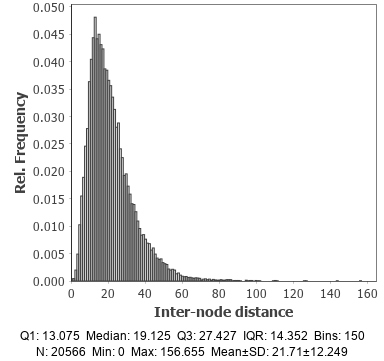

In [13]:
s_stats.getHistogram(metric).show()
# from IPython.display import Image, display
# display(Image(r"C:\Users\cam\Desktop\hist_snapshot.png"))

Let's visualize the Tree. Both 2D and 3D visualizations are supported via the following Classes:

[Viewer2D](https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Viewer2D.html)
[Viewer3D](https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Viewer3D.html)

In [14]:
Viewer2D = autoclass('sc.fiji.snt.viewer.Viewer2D')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')

The 2D viewer renders a projection of the reconstruction (if it is 3 dimensional). To initialize Viewer2D, we need to pass an instance of the [SciJava Context](https://javadoc.scijava.org/SciJava/org/scijava/Context.html) Class to the viewer constructor.

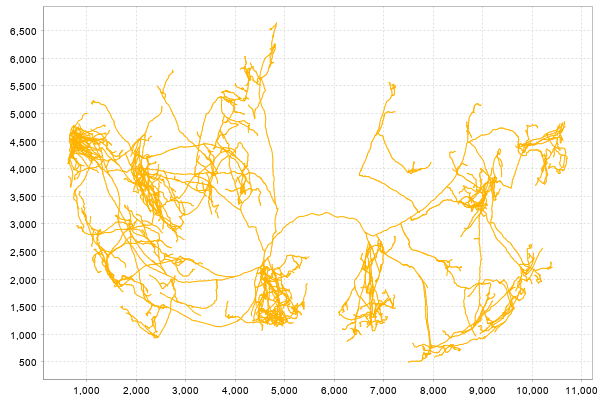

In [15]:
Context = autoclass('org.scijava.Context')
cont = Context()
viewer_2d = Viewer2D(cont)
viewer_2d.add(axon)
viewer_2d.show()

# from IPython.display import Image, display
# display(Image(filename=r"C:\Users\cam\Desktop\viewer_2d_snapshot.png"))

Viewer3D may be initialized using an empty constructor, or with context. Using context instantiates an interactive Viewer3D with GUI Controls to import, manage and customize the Viewer's scene.

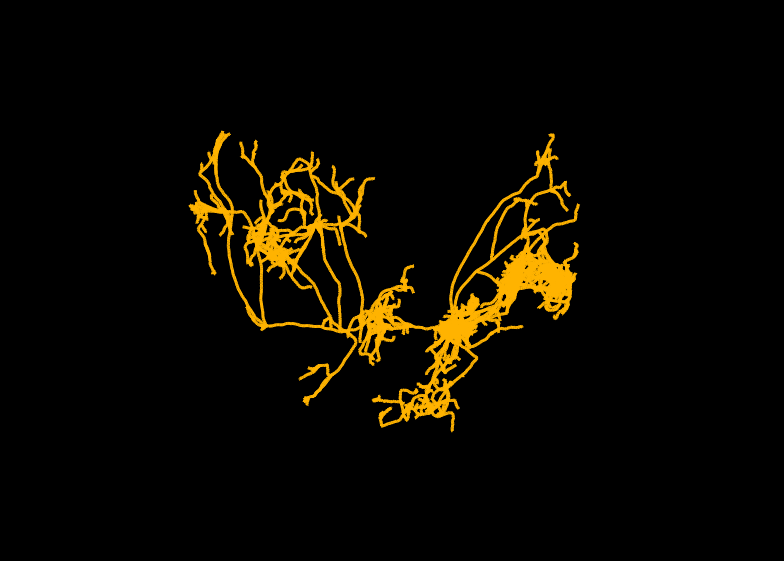

In [16]:
viewer_3d = Viewer3D(cont)
viewer_3d.add(axon)
viewer_3d.show()

# from IPython.display import Image, display
# display(Image(filename=r"C:\Users\cam\Desktop\SNTsnapshots\SNT 2020-03-07 20-12-28.png"))